In [ ]:
# Step 1: Install necessary libraries (if not already installed)
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # Ensure your kaggle.json file is correctly named and placed
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for the Kaggle config file

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d miracle9to9/files1
!unzip -o files1.zip -d /content  # Unzip the dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Set image parameters
input_shape = (128, 128, 3)  # Adjust the shape for your model
batch_size = 32  # Adjust based on your memory capacity

In [ ]:
# Paths to your dataset
train_dir = '/content/Malaria Cells/training_set'
test_dir = '/content/Malaria Cells/testing_set'

In [ ]:
# ImageDataGenerator for training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values to [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Resize images to match the input shape
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for two classes: Parasitised and Uninfected
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

In [ ]:
# Get the number of classes (Parasitised and Uninfected)
num_classes = len(train_generator.class_indices)
# Print dataset shapes
print(f"Train samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")

In [ ]:
# Data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(input_shape[0], input_shape[1]),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation",
)

In [ ]:
# Adapt data augmentation to training data
sample_data, _ = next(train_generator)
data_augmentation.layers[0].adapt(sample_data)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.expand_dims(tf.range(start=0, limit=self.num_patches, delta=1), axis=0)
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

In [ ]:
def mlp(x, hidden_units, dropout_rate=0.1):
    for dim in hidden_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_vit_classifier():
    # Define model input
    inputs = keras.Input(shape=input_shape)

    # Augment data
    augmented = data_augmentation(inputs)

    # Create patches
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    projection_dim = 64
    patches = Patches(patch_size)(augmented)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create transformer blocks
    num_heads = 4
    transformer_layers = 8
    transformer_units = [128, 64]  # Example hidden units for MLP in transformer
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # Final classification layers
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP head
    mlp_head_units = [128, 64]  # Example hidden units for the final classifier
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs
    logits = layers.Dense(num_classes)(features)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [ ]:
# Training parameters
learning_rate = 1e-4
weight_decay = 1e-4
num_epochs = 20  # Adjust based on your needs

In [ ]:
def run_experiment(model):
    # Create the optimizer
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Set up the checkpoint callback
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=num_epochs,
        callbacks=[checkpoint_callback],
    )

    # Load the best model weights
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the test set
    _, accuracy, top_5_accuracy = model.evaluate(test_generator)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [16]:
# Create and train the ViT classifier
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 825s 917ms/step - accuracy: 0.5440 - loss: 0.8442 - top-5-accuracy: 1.0000 - val_accuracy: 0.5798 - val_loss: 0.6490 - val_top-5-accuracy: 1.0000
Epoch 2/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 786s 911ms/step - accuracy: 0.5910 - loss: 0.6624 - top-5-accuracy: 1.0000 - val_accuracy: 0.8589 - val_loss: 0.3521 - val_top-5-accuracy: 1.0000
Epoch 3/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 797s 906ms/step - accuracy: 0.8741 - loss: 0.3492 - top-5-accuracy: 1.0000 - val_accuracy: 0.9128 - val_loss: 0.2422 - val_top-5-accuracy: 1.0000
Epoch 4/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 799s 903ms/step - accuracy: 0.9064 - loss: 0.2901 - top-5-accuracy: 1.0000 - val_accuracy: 0.9142 - val_loss: 0.2545 - val_top-5-accuracy: 1.0000
Epoch 5/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 776s 901ms/step - accuracy: 0.9174 - loss: 0.2582 - top-5-accuracy: 1.0000 - val_accuracy: 0.9229 - val_loss: 0.2371 - val_top-5-accuracy: 1.0000
Epoch 6/20
862/862 ━━━━━━━━━━━━━━━━━━━━ 781s 876ms/step - accuracy: 0.9220 - loss

In [17]:
# Plotting function
def plot_history(history, metric):
    """Plot training and validation metrics over epochs."""
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history["val_" + metric], label="val_" + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(f"Train and Validation {metric.capitalize()} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

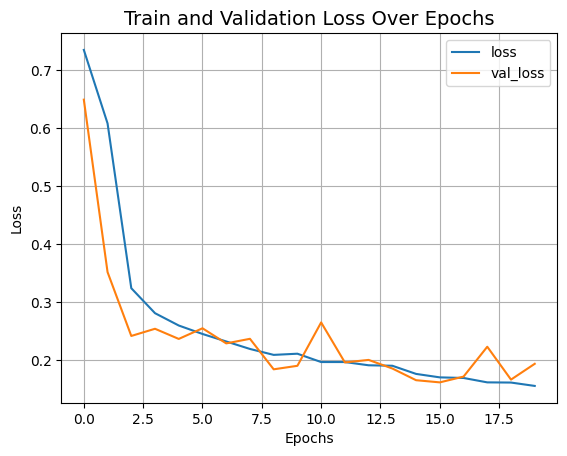

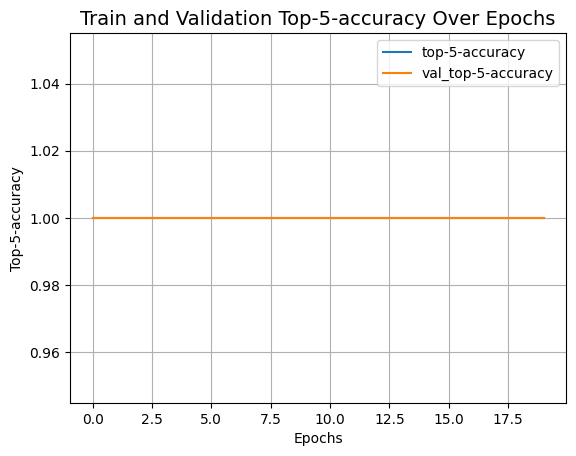

In [18]:
# Plot training and validation loss and top-5 accuracy
plot_history(history, "loss")
plot_history(history, "top-5-accuracy")